In [52]:
%load_ext autoreload
%autoreload 2

#import standard libs
from IPython.display import display
#from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json
import pandas as pd
import pandas_datareader.data as web
pd.set_option('display.max_rows', 100)

from dask import dataframe as dd
from dask.diagnostics import ProgressBar

pbar = ProgressBar()
pbar.register()

import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math
#import pymc3 as pm
#from theano import shared, theano as tt

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
import missingno as msno



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
%matplotlib inline
plt.style.use('seaborn-talk')
plt.style.use('bmh')

#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 12,8
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# get project dir
pp = PurePath(Path.cwd()).parts[:-2]
print(pp)
pdir = PurePath(*pp)
script_dir = pdir / 'src' 
viz_dir = pdir / 'report' / 'figures'
data_dir = pdir / 'data'
script_dirs = list(Path(script_dir).glob('./*/'))
for sdir in script_dirs: sys.path.append(sdir.as_posix())

# import python scientific stack

RANDOM_STATE = 777

from utils import *
from bars import *

('/', 'home', 'ale', 'py-projects', 'Adv_Fin_ML_Exercises')


In [3]:
infp=PurePath(data_dir/'interim'/'IVE_tickbidask.parq')
df = pd.read_parquet(infp)
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask   size      v          dv
dates                                                                
2018-10-19 15:59:59  111.96  111.95  111.96    900    900   100764.00
2018-10-19 16:00:00  111.97  111.95  111.96  12439  12439  1392794.83
2018-10-19 16:10:00  111.97  111.31  112.10      0      0        0.00
2018-10-19 18:30:00  111.97  110.70  112.40      0      0        0.00
2018-10-19 20:00:00  111.97  110.81  112.40      0      0        0.00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1431009 entries, 2009-09-28 09:30:00 to 2018-10-19 20:00:00
Data columns (total 6 columns):
price    1431009 non-null float64
bid      1431009 non-null float64
ask      1431009 non-null float64
size     1431009 non-null int6

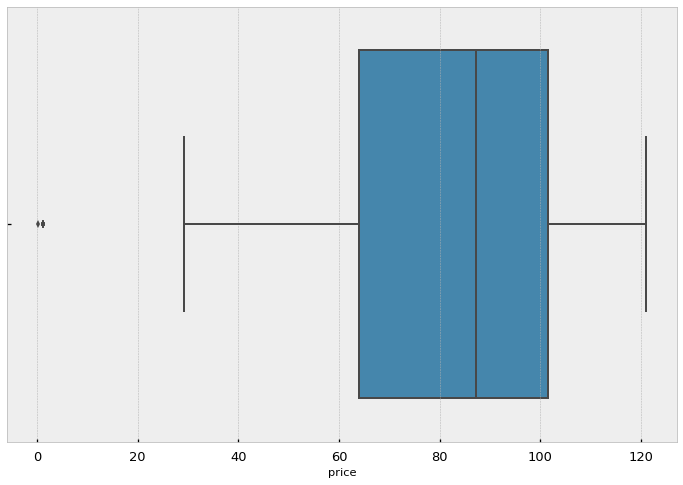

In [4]:
sns.boxplot(df.price)

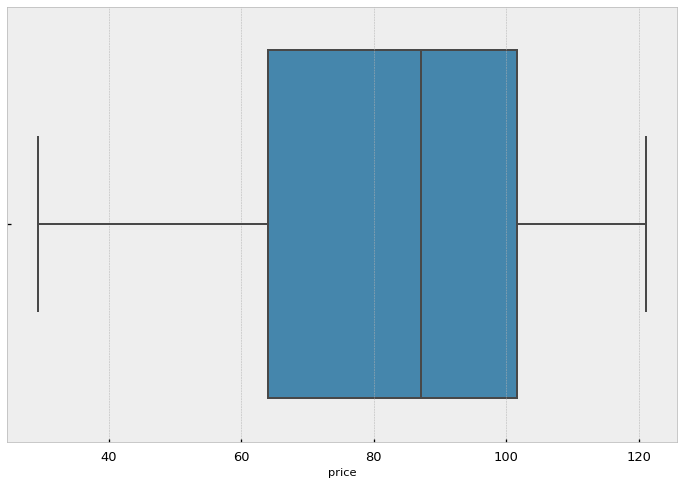

In [5]:
mad = mad_outlier(df.price.values.reshape(-1,1))
df = df.loc[~mad]
sns.boxplot(df.price)

In [6]:
dollar_M = 1_000_000 # arbitrary 
#print(f'dollar threshold: {dollar_M:,}')
dv_bar_df = dollar_bar_df(df, 'dv', dollar_M)
cprint(dv_bar_df)

100%|██████████| 1430998/1430998 [00:00<00:00, 2640045.57it/s]

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask   size      v          dv
dates                                                                
2018-10-19 15:57:50  112.09  112.08  112.09   1500   1500   168135.00
2018-10-19 15:59:07  112.01  112.00  112.01    306    306    34275.06
2018-10-19 15:59:37  111.96  111.96  111.97    313    313    35043.48
2018-10-19 15:59:58  111.97  111.96  111.98   1586   1586   177584.42
2018-10-19 16:00:00  111.97  111.95  111.96  12439  12439  1392794.83
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51439 entries, 2009-09-28 09:46:35 to 2018-10-19 16:00:00
Data columns (total 6 columns):
price    51439 non-null float64
bid      51439 non-null float64
ask      51439 non-null float64
size     51439 non-null int64
v       

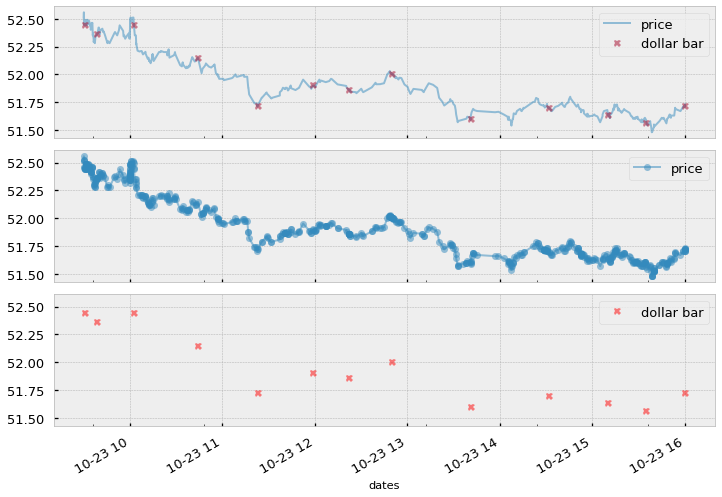

In [7]:
xDate ='2009-10-23' #'2017-10-4'
xdf, xtdf = select_sample_data(df, dv_bar_df, 'price', xDate)

plot_sample_data(xdf, xtdf, 'dollar bar', alpha=0.5, markersize=7)

In [8]:
tick_M = 200 # arbitrary
tick_df = tick_bar_df(df, 'price', tick_M)

100%|██████████| 1430998/1430998 [00:00<00:00, 2718756.32it/s]


In [9]:
tick_ret = returns(tick_df.price)
dv_ret = returns(dv_bar_df.price)
dv_ret.autocorr()

bench_ret = np.random.randn(tick_ret.shape[0])

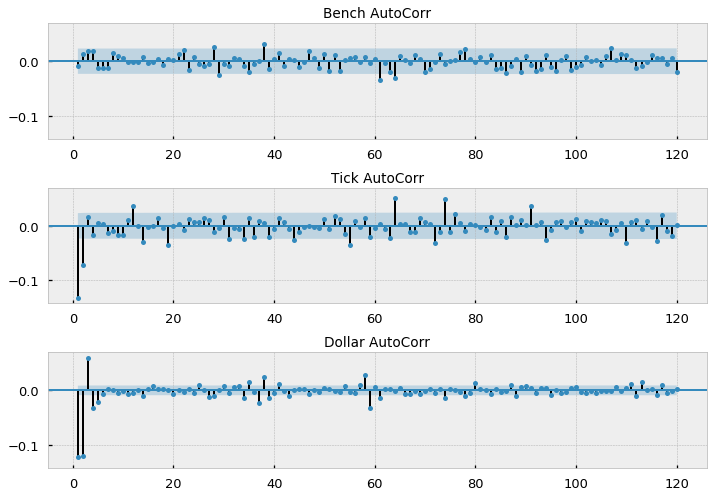

In [10]:
plot_autocorr(bar_types=['Bench', 'Tick', 'Dollar'], bar_returns=[bench_ret, tick_ret, dv_ret])

In [11]:
bar_types= ['Bench', 'Tick', 'Dollar'] 
bar_returns = [bench_ret, tick_ret, dv_ret]

get_test_stats(bar_types,bar_returns,jb).sort_values('jb_stat')

,sample_size,jb_stat
Bench,7153.0,5.772817e-01
Tick,7153.0,1.127301e+08
Dollar,51438.0,5.559126e+10


In [12]:
get_test_stats(bar_types,bar_returns,shapiro).sort_values('shapiro_stat')[::-1]

,sample_size,shapiro_stat
Bench,7153.0,0.999764
Tick,7153.0,0.592870
Dollar,51438.0,0.407535


51438it [00:14, 3479.87it/s]


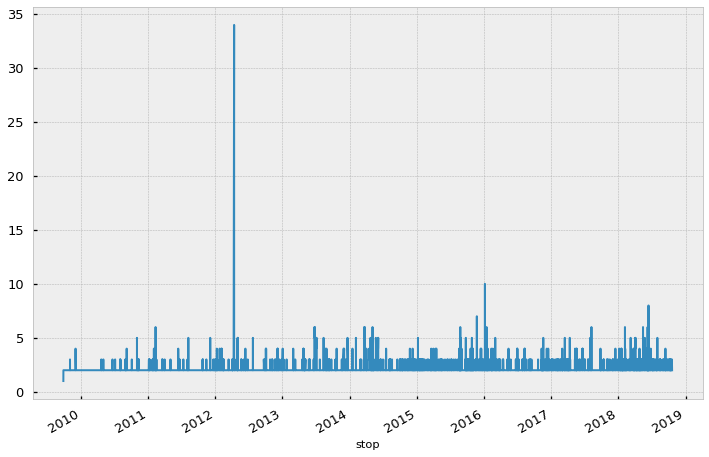

In [13]:
imb_bars, df_ts = get_imbalanced_df(dv_bar_df, price_column='price', imbalanced_column='dv',wsize=1000)
#imb_bars = get_imbalanced_df(df=dv_bar_df)

In [14]:
print(dv_bar_df.shape, df.shape, imb_bars.shape, df_ts.shape)
df_ts.Ts.describe()

(51439, 6) (1430998, 6) (51403, 6) (51254, 3)


count    51254.000000
mean         2.033812
std          0.270724
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         34.000000
Name: Ts, dtype: float64

In [15]:
infp = PurePath(data_dir/'processed'/'IVE_dollarValue_resampled_1s.parquet')
df = pd.read_parquet(infp)
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask  size     v         dv
dates                                                             
2018-09-04 15:59:55  115.93  115.92  115.93   803   803   93091.79
2018-09-04 15:59:56  115.92  115.91  115.92   155   155   17967.60
2018-09-04 16:00:00  115.92  115.91  115.92  8570  8570  993434.40
2018-09-04 16:10:00  115.92  114.46  117.06     0     0       0.00
2018-09-04 18:30:00  115.92  115.35  116.57     0     0       0.00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1010793 entries, 2009-09-28 09:30:00 to 2018-09-04 18:30:00
Data columns (total 6 columns):
price    1010793 non-null float64
bid      1010793 non-null float64
ask      1010793 non-null float64
size     1010793 non-null int64
v        1010793 no

In [16]:
dv_1s_ret = returns(df.price)
imb_ret = returns(imb_bars.price)
bar_types= ['Bench','Tick', 'Dollar', 'Imb', 'Dollar1s'] 
bar_returns = [bench_ret, tick_ret, dv_ret, imb_ret, dv_1s_ret]

In [17]:
get_test_stats(bar_types,bar_returns,jb).sort_values('jb_stat')

,sample_size,jb_stat
Bench,7153.0,5.772817e-01
Tick,7153.0,1.127301e+08
Imb,51402.0,5.547796e+10
Dollar,51438.0,5.559126e+10
Dollar1s,1010792.0,1.615504e+13


In [18]:
get_test_stats(bar_types,bar_returns,shapiro).sort_values('shapiro_stat')[::-1]

,sample_size,shapiro_stat
Bench,7153.0,0.999764
Tick,7153.0,0.592870
Dollar,51438.0,0.407535
Imb,51402.0,0.407358
Dollar1s,1010792.0,0.286396


In [19]:
#outfp = PurePath(data_dir/'processed'/'dv_imbalanced_bars.parq')
#imb_bars = pd.read_parquet(outfp)
#cprint(imb_bars)

In [24]:
close = df.price.copy()
dailyVol = getDailyVol(close, span0=1000)
cprint(dailyVol.to_frame())

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     dailyVol
dates                        
2018-09-04 15:59:55  0.002106
2018-09-04 15:59:56  0.002105
2018-09-04 16:00:00  0.002104
2018-09-04 16:10:00  0.002102
2018-09-04 18:30:00  0.002101
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1010043 entries, 2009-09-29 09:30:02 to 2018-09-04 18:30:00
Data columns (total 1 columns):
dailyVol    1010042 non-null float64
dtypes: float64(1)
memory usage: 15.4 MB
None
-------------------------------------------------------------------------------



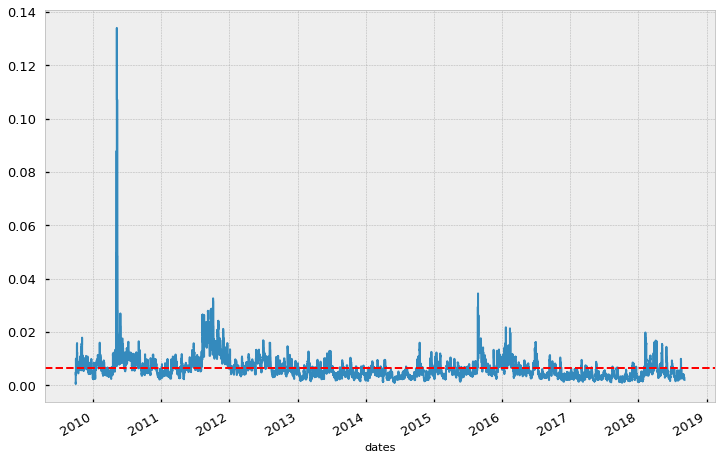

In [25]:
dailyVol.plot()
plt.axhline(dailyVol.mean(),ls='--',color='red')
plt.show()

In [26]:
tEvents = getTEvents(close, h=dailyVol.mean())
tEvents

100%|██████████| 1010791/1010791 [02:55<00:00, 5753.53it/s]


DatetimeIndex(['2009-09-28 09:47:45', '2009-09-28 11:31:17',
               '2009-09-29 09:03:17', '2009-09-29 10:00:58',
               '2009-09-29 11:00:13', '2009-09-29 13:01:14',
               '2009-09-30 09:43:21', '2009-09-30 09:48:12',
               '2009-09-30 12:32:29', '2009-09-30 13:05:29',
               ...
               '2018-08-16 08:04:29', '2018-08-16 12:03:51',
               '2018-08-17 14:05:16', '2018-08-20 07:00:00',
               '2018-08-20 09:30:00', '2018-08-21 11:40:08',
               '2018-08-23 09:30:00', '2018-08-27 09:30:00',
               '2018-08-30 11:26:38', '2018-08-31 12:07:04'],
              dtype='datetime64[ns]', length=5332, freq=None)

xdf shape: (429,), xtdf shape: (7,)


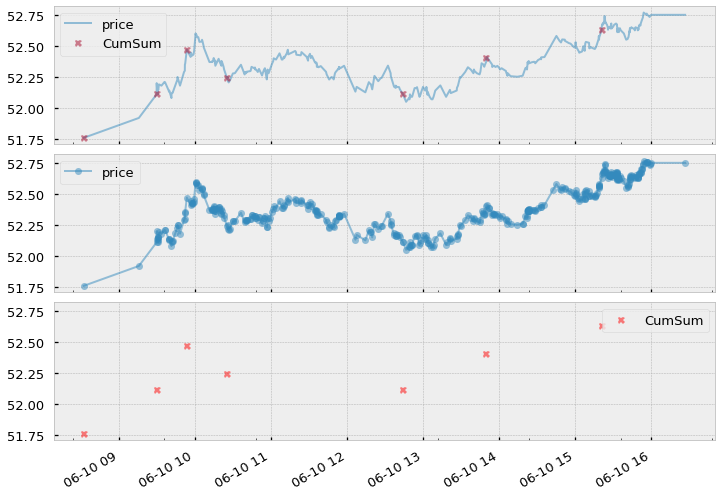

In [27]:
xDate = '2010-06-10'
xdf, xtdf = select_sample_data(df, df.loc[tEvents], 'price', xDate)
print(f'xdf shape: {xdf.shape}, xtdf shape: {xtdf.shape}')

plot_sample_data(xdf, xtdf, 'CumSum', alpha=0.5, markersize=7)  

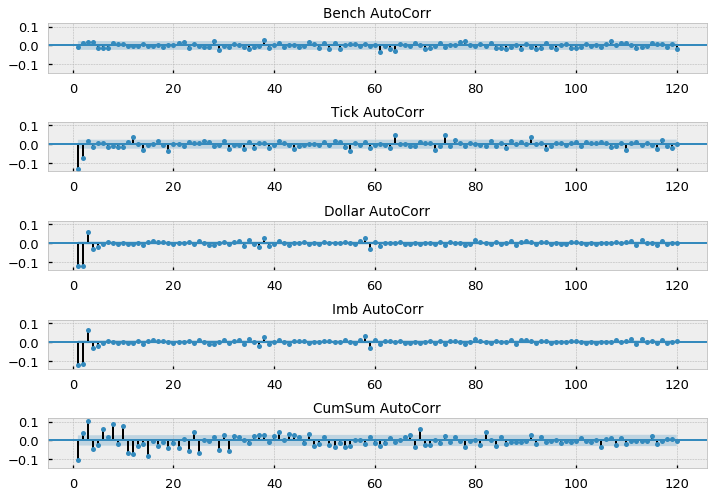

In [28]:
cum_sum_ret = returns(df.loc[tEvents].price)
bar_types= ['Bench','Tick', 'Dollar', 'Imb', 'CumSum'] 
bar_returns = [bench_ret, tick_ret, dv_ret, imb_ret, cum_sum_ret]
plot_autocorr(bar_types=bar_types, bar_returns=bar_returns)

In [29]:
get_test_stats(bar_types,bar_returns,jb).sort_values('jb_stat')

,sample_size,jb_stat
Bench,7153.0,5.772817e-01
CumSum,5331.0,2.449040e+06
Tick,7153.0,1.127301e+08
Imb,51402.0,5.547796e+10
Dollar,51438.0,5.559126e+10


In [30]:
get_test_stats(bar_types,bar_returns,shapiro).sort_values('shapiro_stat')[::-1]

,sample_size,shapiro_stat
Bench,7153.0,0.999764
CumSum,5331.0,0.673030
Tick,7153.0,0.592870
Dollar,51438.0,0.407535
Imb,51402.0,0.407358


In [31]:
t1 = addVerticalBarrier(tEvents, close)

In [36]:
ptsl = [1,1]
target=dailyVol
# select minRet
minRet = 0.01
# get cpu count - 1
cpus = 1
events = getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1)
#cprint(events)

In [63]:
events_ = events.dropna(subset=['t1'])
print(events.shape, events_.shape)
px = events_.index.union(events_['t1'].values).drop_duplicates()
px = close.reindex(px, method='bfill')
out  = pd.DataFrame(index=events_.index)
out['ret'] = px.loc[events_['t1'].values].values/px.loc[events_.index.values].values - 1
if 'side' in events_: out['ret'] *= events_['side']

out['bin'] = np.sign(out['ret'])

if 'side' in events_: out.loc[out['ret'] <= 0, 'bin'] = 0 #meta-labeling
    
#cprint(out)

(1856, 2) (1856, 2)


In [64]:
labels = getBins(events, close)
clean_labels = dropLabels(labels)
clean_labels.bin.value_counts()

dropped label:  0.0 0.0016163793103448276


 1.0    1031
-1.0     822
Name: bin, dtype: int64

## [3.5] Develop mean-reverting Bollinger Band Strategy. For each obs. model suggests a side but not size of the bet.

In [65]:
window=50
bb_df = pd.DataFrame()
bb_df['price'],bb_df['ave'],bb_df['upper'],bb_df['lower']=bbands(close, window=window, numsd=1)
bb_df.dropna(inplace=True)
#cprint(bb_df)

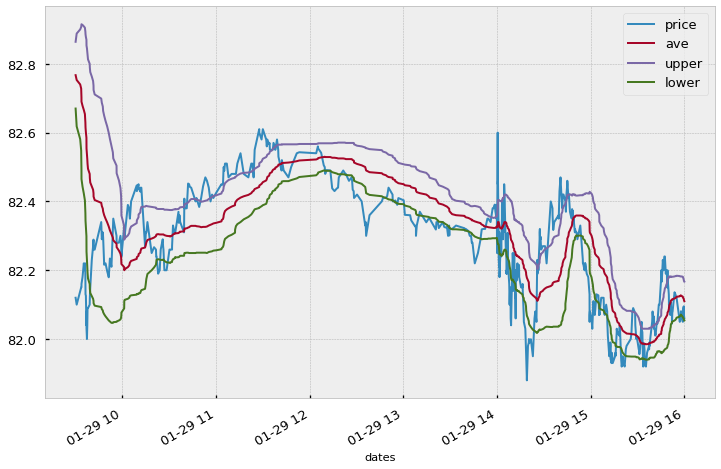

In [66]:
from_date, to_date = '2014-01-29', '2014-01-29'
bb_df.loc[from_date:to_date].plot()
plt.show()

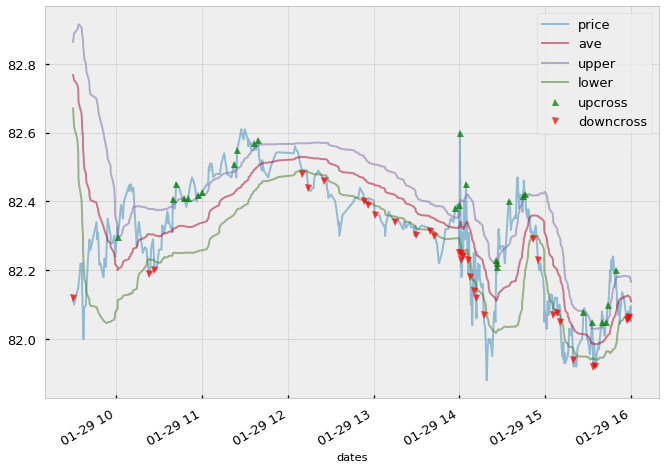

In [67]:
bb_down = get_down_cross(bb_df, 'price')
bb_up = get_up_cross(bb_df, 'price') 

f, ax = plt.subplots(figsize=(11,8))

bb_df.loc[from_date:to_date].plot(ax=ax, alpha=.5)
bb_up.loc[from_date:to_date].plot(ax=ax, ls='', marker='^', markersize=7,
                        alpha=0.75, label='upcross', color='g')
bb_down.loc[from_date:to_date].plot(ax=ax, ls='', marker='v', markersize=7, 
                          alpha=0.75, label='downcross', color='r')
ax.legend()

In [68]:
bb_side_up = pd.Series(-1, index=bb_up.index) # sell on up cross for mean reversion
bb_side_down = pd.Series(1, index=bb_down.index) # buy on down cross for mean reversion
bb_side_raw = pd.concat([bb_side_up,bb_side_down]).sort_index()
#cprint(bb_side_raw)

minRet = .01 
ptsl=[0,2]
bb_events = getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1,side=bb_side_raw)
#cprint(bb_events)

bb_side = bb_events.dropna().side

In [49]:
bb_side.value_counts()

-1.0    165
 1.0    135
Name: side, dtype: int64

In [50]:
bb_bins = getBins(bb_events,close).dropna()

In [51]:
bb_bins.bin.value_counts()

0.0    172
1.0    128
Name: bin, dtype: int64

In [61]:
srl_corr = df_rolling_autocorr(returns(close), window=window).rename('srl_corr')
#cprint(srl_corr)

In [69]:
features = (pd.DataFrame()
            .assign(vol=bb_events.trgt)
            .assign(ma_side=bb_side)
            .assign(srl_corr=srl_corr)
            .drop_duplicates()
            .dropna())
cprint(features)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          vol  ma_side  srl_corr
2018-04-09 09:30:00  0.011345     -1.0 -0.012064
2018-04-10 09:30:00  0.012785     -1.0  0.016046
2018-05-04 20:12:10  0.012085      1.0 -0.030903
2018-05-07 09:30:00  0.012123     -1.0 -0.758457
2018-06-01 09:30:00  0.010921     -1.0  0.051418
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2009-10-06 09:45:02 to 2018-06-01 09:30:00
Data columns (total 3 columns):
vol         300 non-null float64
ma_side     300 non-null float64
srl_corr    300 non-null float64
dtypes: float64(3)
memory usage: 9.4 KB
None
-------------------------------------------------------------------------------



In [70]:
Xy = (pd.merge_asof(features, bb_bins[['bin']], 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
cprint(Xy)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          vol  ma_side  srl_corr  bin
2018-04-09 09:30:00  0.011345     -1.0 -0.012064  0.0
2018-04-10 09:30:00  0.012785     -1.0  0.016046  1.0
2018-05-04 20:12:10  0.012085      1.0 -0.030903  1.0
2018-05-07 09:30:00  0.012123     -1.0 -0.758457  1.0
2018-06-01 09:30:00  0.010921     -1.0  0.051418  0.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2009-10-06 09:45:02 to 2018-06-01 09:30:00
Data columns (total 4 columns):
vol         300 non-null float64
ma_side     300 non-null float64
srl_corr    300 non-null float64
bin         300 non-null float64
dtypes: float64(4)
memory usage: 11.7 KB
None
-------------------------------------------------------------------------------



In [71]:
Xy.bin.value_counts()

0.0    172
1.0    128
Name: bin, dtype: int64

In [76]:
from sklearn.model_selection import train_test_split

In [77]:


X = Xy.drop('bin',axis=1).values
print(X[0:3])
y = Xy['bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

[[ 0.01566404 -1.          0.0078005 ]
 [ 0.01015732 -1.          0.41645146]
 [ 0.01074317 -1.         -0.01289155]]


              precision    recall  f1-score   support

    no_trade       0.56      0.55      0.55        88
       trade       0.38      0.40      0.39        62

   micro avg       0.49      0.49      0.49       150
   macro avg       0.47      0.47      0.47       150
weighted avg       0.49      0.49      0.49       150



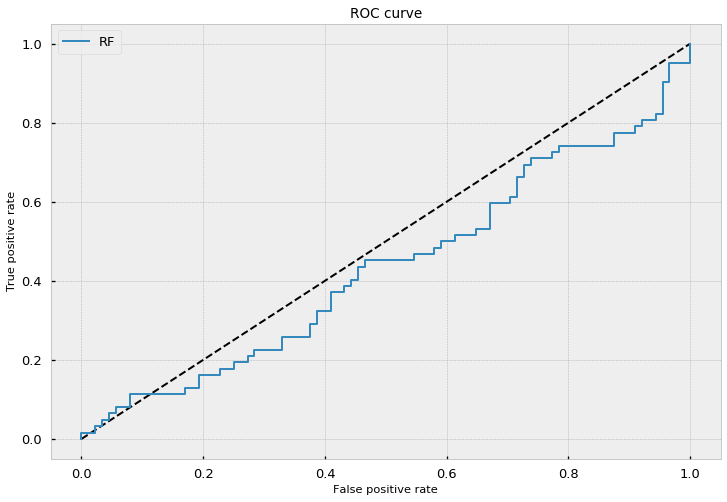

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, classification_report

n_estimator = 10000
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names=['no_trade','trade']))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()